# Маятник

Уравнение маятника
\begin{align}
x''(t)+\omega^2 \sin{x(t)}=0, \\
x(0) = x_0,
x'(0) = 0.
\end{align}

Введем замену переменных $v(t) = x'(t)$, чтобы перейти от одного дифференциального уравнения второго порядка к системе дифференциальных уравнений первого порядка:
\begin{align}
\begin{cases}
x'(t) = v(t), \\
v'(t) = -\omega^2 \sin{x(t)}, \\
x(0) = x_0, \\
v(0) = 0.
\end{cases}
\end{align}


### Подготовка
Подготовим необходимые функции, чтобы решить уравнение маятника численно и оценить наше решение.


**1)** Определим функцию, вычисляющую правую часть системы уравнений

In [ ]:
import numpy as np

g = 9.8  # acceleration due to gravity, in m/s^2
l = 1.0  # length of pendulum in m

omega = np.float64((g/l)**(1/2))

#state[0] = x(0), state[1] = v(0)

def calcRHS(state):
    return np.array([state[1], -omega**2*sin(state[0])])

**2)** Определим функцию, которая вычисляет значение на следующем шаге по времени при помощи явного метода Эйлера

In [ ]:
def explicitEuler(calcRHS, state, dt):
    return state + dt*calcRHS(state)

**3)** Определим функцию, которая производит интегрирование уравнения маятника. В качестве аргументов эта функция принимает начальное состояние системы $\textrm{ini_state}$, метод интегрирования по времени $\textrm{method}$, размер шага интегрирования по времени $\textrm{dt}$ и количество шагов по времени $\textrm{Nt}$.

In [ ]:
import numpy as np
def solvePendulumEquation(ini_state, method, dt, Nt):

    # ini_state - initial conditions
    # method - time integration scheme
    # dt - time step size
    # Nt - number of time steps

    # create array to store solution at every time point
    sol = np.zeros([Nt+1, 2])
    sol[0,:] = ini_state
    for i in range (1, Nt+1):
        sol[i,:] = method(calcRHS, sol[i-1,:], dt)
    return sol

**4)** Также, нам понадобится функция, чтобы визуализировать решение маятника. В ее подробности можно пока не вдаваться.

In [ ]:
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib notebook
def animatePendulum(sol):
    # Animation related stuff
    x1 =  l*sin(sol[:, 0])
    y1 = -l*cos(sol[:, 0])

    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
    ax.set_aspect('equal',  adjustable='box')
    ax.grid()

    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

    def animate(i):
        thisx = [0, x1[i]]
        thisy = [0, y1[i]]

        line.set_data(thisx, thisy)
        time_text.set_text(time_template % (i*dt))
        return line, time_text

    ani = animation.FuncAnimation(fig, animate, range(1, len(sol)), interval=dt*1000, blit=True, repeat=False)
    plt.show()
    return(ani)

### Проинтегрируем уравнение маятника по времени и нарисуем решение:

In [ ]:
ini_state = np.array([pi/4, 0.0])
Nt = 200
dt = 0.05

sol = solvePendulumEquation(ini_state, explicitEuler, dt, Nt)

ani=animatePendulum(sol)

<IPython.core.display.Javascript object>

Можно сохранить анимацию в виде гифки

In [ ]:
# ani.save('pendulumAnimation.gif', fps=25)

### Вопрос
Не кажется ли вам, что решение выглядит нереалистично? В чем врет численная схема?
<details>
    <summary><b><u><color="blue">Узнать ответ (нажми)</color></u></b></summary>
    Амплитуда колебаний нарастает. Так происходить не должно! (Выполняется закон сохранения энергии)
</details>

**Понять, почему так происходит можно, если немного изучить теорию схем интегрирования по времени.**

# Теория схем интегрирования по времени

## 0) Прежде, чем начать...
Мы будем изучать систему уравнений в виде
\begin{equation}
f' = R(f),
\end{equation}
с начальным условием
\begin{equation}
f(t=0) = f^0.
\end{equation}

Численное решение в момент времени $n\Delta t$ мы будем называть решением на шаге $n$ и обозначать $f^n$.

Уравнение маятника тоже можно записать в виде $f=R(f)$.

## 1) Точность решения
При малых шагах по времени $\Delta t$, решение системы уравнений можно представить в виде ряда Тейлора:
\begin{equation}
f(t+\Delta t) = f(t)+\frac{d f}{dt}(t) \Delta t+\frac{d^2 f}{dt^2}(t) \frac{\Delta t^2}{2}+\mathrm{O}(\Delta t^3).
\end{equation}

Решение метода Эйлера можно выписать в похожей форме:
\begin{equation}
f_E(t+\Delta t) = f(t)+\frac{d f}{dt}(t) \Delta t.
\end{equation}

Ошибка решения метода Эйлера на одном шаге
\begin{equation}
e=\lvert f(t+\Delta t)-f_E(t+\Delta t)\rvert = \left\lvert\frac{d^2 f}{dt^2}(t) \frac{\Delta t^2}{2}+\mathrm{O}(\Delta t^3)\right \rvert,
\end{equation}
где наибольшее слагаемое пропорционально $\Delta t^2$.

Если нужно проинтегрировать уравнение на время $T$, то ошибки за несколько шагов сложатся и итоговая ошибка будет пропорциональна
\begin{equation}
e\sim N\Delta t^2\sim \frac{T}{\Delta t}\Delta t^2 = T\Delta t.
\end{equation}.

Говорят, что метод Эйлера имеет первый порядок точности (ошибка пропорциональна $\Delta t^1$). Если шаг по времени уменьшить в 2 раза, то и ошибка упадет в 2 раза.

#### Эксперимент
Проверьте, как изменится численное решение уравнения маятника при уменьшении шага по времени. Рост амплитуды прекратится?

### Метод интегрирования по времени 2-го порядка точности
Достаточно простой метод интегрирования по времени с лучшей точностью, чем у явного Эйлера - метод предиктор-корректор:
\begin{align}
\tilde f &= f^n+\Delta t R(f^n), \\
f^{n+1} &= f^n+\frac{\Delta t}{2}\left(R(f^n)+R(\tilde f)\right).
\end{align}

#### Упражнение
Запрограммируйте этот метод и примените для интегрирования маятника. Решение отличается от решения методом Эйлера?

In [ ]:
def PredictorCorrector(calcRHS, state, dt):
  state1 = state+dt*calcRHS(state)
  return state+(dt*0.5)*(calcRHS(state)+calcRHS(state1))

In [ ]:
ini_state = np.array([pi/4, 0.0])
Nt = 200
dt = 0.1

sol = solvePendulumEquation(ini_state, PredictorCorrector, dt, Nt)

ani=animatePendulum(sol)
ani.save('pendulumAnimation.gif', fps=25)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


### Метод Рунге-Кутты 4-го порядка точности
Еще более точный метод:
\begin{align}
k_1 &= R(f^n), \\
k_2 &= R(f^n+\Delta t k_1/2), \\
k_3 &= R(f^n+\Delta t k_2/2), \\
k_4 &= R(f^n+\Delta t k_3), \\
f^{n+1} &= f^n+\frac{\Delta t}{6}\left(k_1+2k_2+2k_3+k_4\right)
\end{align}
Запрограммируйте этот метод и проинтегрируйте маятник с его помощью. Если метод четвертого порядка точности, то во сколько раз должна уменьшиться ошибка, при уменьшении шага по времени в два раза?

In [ ]:
def RK4(calcRHS, state, dt):
  k1 = calcRHS(state)
  k2 = calcRHS(state+dt*0.5*k1)
  k3 = calcRHS(state+dt*0.5*k2)
  k4 = calcRHS(state+dt*k3)
  return state+dt*(1/6)*(k1+2*k2+2*k3+k4)

In [ ]:
ini_state = np.array([pi/4, 0.0])
Nt = 200
dt = 0.1

sol = solvePendulumEquation(ini_state, RK4, dt, Nt)

ani=animatePendulum(sol)
ani.save('pendulumAnimation.gif', fps=25)

<IPython.core.display.Javascript object>

## 2) Как проверить точность схемы экспериментально?
Хорошо, когда у задачи есть аналитическое решение. У уравнения маятника такого решения нет, зато оно есть у уравнения "линейного" маятника:
\begin{equation}
x'' + \omega^2 x=0,
\end{equation}
которое можно привести к виду $f = (x,v)^T$, $f' = Rf$
\begin{equation}
R =
\begin{pmatrix}
0 & 1 \\ -\omega^2 & 0
\end{pmatrix}.
\end{equation}

Аналитическое решение, при $x(t=0)=x_0$, $v(t=0) = 0$, $x(t) = x_0 \cos(\omega t)$. Давайте проведем исследование на примере этого уравнения.

**Шаг 1** Напишите функцию, вычисляющую правую часть для линейного маятника:

In [ ]:
def calcRHS_lin(state):
    ### Remove before training
    return np.array([state[1], -omega**2*state[0]])

**Шаг 2** Сделаем функцию решающую линейный маятник (это просто дубль функции для нелинейного маятника с другой правой частью):

In [ ]:
import numpy as np
def solveLinPendulumEquation(ini_state, method, dt, Nt):

    # ini_state - initial conditions
    # method - time integration scheme
    # dt - time step size
    # Nt - number of time steps

    # create array to store solution at every time point
    sol = np.zeros([Nt+1, 2])
    sol[0,:] = ini_state
    for i in range (1, Nt+1):
        sol[i,:] = method(calcRHS_lin, sol[i-1,:], dt)
    return sol

Решим уравнение линейного маятника и нарисуем результат (функцию анимации можно оставить как есть):

In [ ]:
ini_state = np.array([pi/4, 0.0])
Nt = 200
dt = 0.05

sol = solveLinPendulumEquation(ini_state, explicitEuler, dt, Nt)

ani=animatePendulum(sol)

<IPython.core.display.Javascript object>

In [ ]:
ani.save('pendulumAnimation.gif', fps=25)

В чем отличие от нелинейного случая? Метод Эйлера по прежнему увеличивает амплитуду?

Давайте нарисуем "осциллограмму решения" - зависимость $x$ от $t$ для численного и аналитического решения. Кроме того, выведем величину ошибки решения в конце промежутка времени.

In [ ]:
ini_state = np.array([pi/4, 0.0])
Nt = 200
dt = 0.05

sol = solveLinPendulumEquation(ini_state, explicitEuler, dt, Nt)

t = np.arange(0,Nt+1)*dt
analytic = ini_state[0]*np.cos(omega*t)

fig = plt.figure()
plt.scatter(t,sol[:,0])
plt.plot(t,analytic,color="red")
plt.show()
# print("Ошибка: ",sol[-1,0]-analytic[-1])

AttributeError: 'NoneType' object has no attribute 'remove_callback'

### Упражнение
Проверьте точность разных методов интегрирования по времени. Как зависит ошибка от шага по времени?

## 3) Устойчивость
И все-таки, почему решение методом Эйлера так сильно разбалтывается?
<details>
    <summary>===Объяснение на пальцах (жми!) ===</summary>
    Метод Эйлера не учитывает, что возвращающая сила маятника увеличивается по мере того, как он улетает от положения равновесия. Численный маятник проскочит дальше чем проскочит место, где остановится реальный маятник. Т.е. его суммарная энергия вырастет. На следующем цикле все повториться...
</details>

В теории численных методов есть важное понятие устойчивости. Это когда маленькие возмущения решения не растут со временем. В случае маятника устойчивость равносильна тому, что энергия колебаний не нарастает.

Для исследования устойчивости рассмотрим совсем простое уравнение
\begin{equation}
f' = i\omega f,
\end{equation}
где $i$ - комплексная единица, $f$ - комплексное число. Кстати, это уравнение равносильно системе уравнений линейного маятника, а модуль решения $|f|$ - корень из энергии колебаний маятника.

Если решать это уравнение **аналитически**, то
$$
f^{n+1} = \exp\{i\omega \Delta t\} f^n.
$$
Можно показать, что
$$
|f^{n+1}| = |\exp\{i\omega \Delta t\}|\cdot|f^n| = |f^n|.
$$
Это и значит, что  энергия решения и, значит, амплитуда колебаний сохраняется.

**Что же делает с амплитудой метод Эйлера?**
Попробуйте сами вычислить
<details>
    <summary><h4>(нажми, чтобы узнать или сверить ответ!)</h4></summary>
    $$
    f^{n+1} = f^n+i\omega\Delta t f^n,
    $$
    $$
    |f^{n+1}| = |1+i\omega\Delta t|| f^n| = \sqrt{1+\omega^2\Delta t^2}| f^n|.
    $$
    Получается, что каждый шаг по времени энергия колебаний умножается на величину $\sqrt{1+\omega^2\Delta t^2}$, которая больше 1. Явный метод Эйлера всегда неустойчив, при любой частоте $\omega$ и любом шаге по времени, кроме нулевых.
</details>

**Оператор перехода**

Для любой схемы по времени можно записать
$$
f^{n+1} = S f^{n},
$$
где $S$ - оператор перехода. За устойчивость отвечает модуль оператора перехода, если $|S| \le 1$, то схема устойчива.
Для схемы предиктор-корректор оператор перехода равен
<details>
    <summary><b>(нажми, чтобы узнать или сверить ответ)</b></summary>
    $$
    S = 1+i\omega\Delta t-\frac{1}{2}\omega^2\Delta t^2,
    $$
    $$|S| = 1+(\omega\Delta t)^4$$
    Предиктор-корректор тоже всегда неустойчивый, но горазно слабее, чем метод Эйлера, так как $\omega\Delta t$ обычно маленькая величина.
</details>

Оператор перехода для схемы РК4 равен
$$
1+i\omega\Delta t-\frac{1}{2}\omega^2\Delta t^2-\frac{1}{6}i\omega^3\Delta t^3+\frac{1}{24}\omega^4\Delta t^4.
$$

#### Упраженние
Постройте график модуля оператора перехода для схемы РК4 при $\omega\Delta t \in [0,\pi]$. Что можно сказать про устойчивость схемы РК4?

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

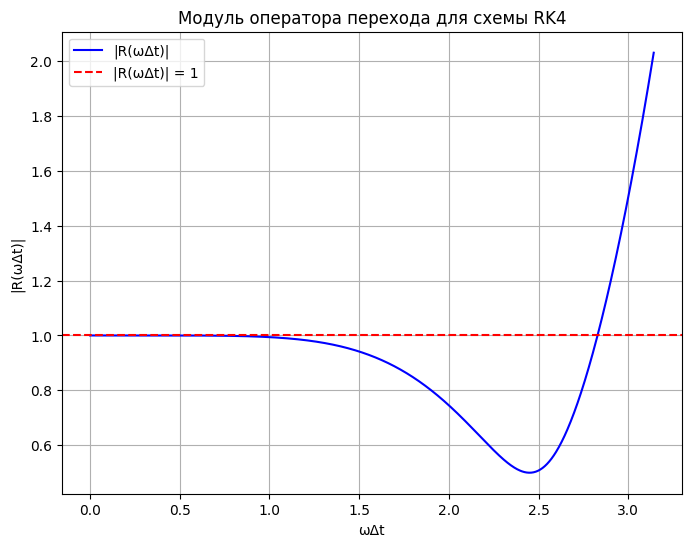

AttributeError: 'NoneType' object has no attribute 'remove_callback'

<IPython.core.display.Javascript object>

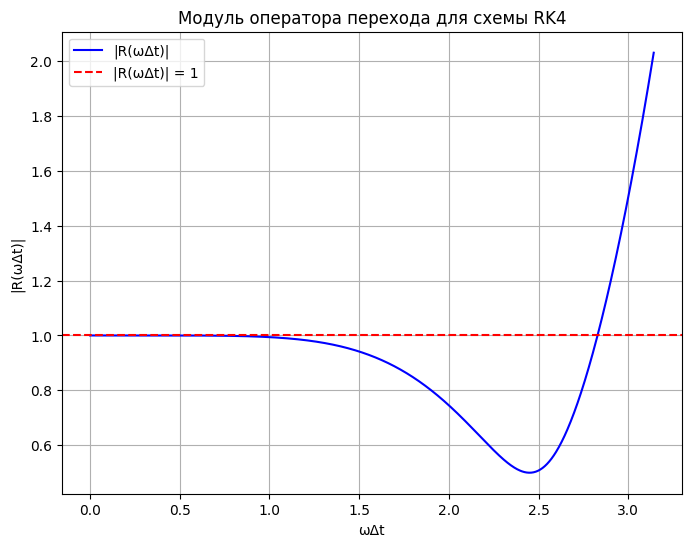

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Определяем функцию для вычисления модуля оператора перехода
def transition_operator(w_dt):
    return np.abs(1 + 1j * w_dt - 0.5 * w_dt**2 - (1j / 6) * w_dt**3 + (1 / 24) * w_dt**4)

# Диапазон значений omega * dt
w_dt_values = np.linspace(0, np.pi, 1000)

# Вычисляем модуль оператора перехода для каждого значения omega * dt
modulus = transition_operator(w_dt_values)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(w_dt_values, modulus, label='|R(ωΔt)|', color='blue')
plt.axhline(1, color='red', linestyle='--', label='|R(ωΔt)| = 1')  # Линия для |R| = 1
plt.xlabel('ωΔt')
plt.ylabel('|R(ωΔt)|')
plt.title('Модуль оператора перехода для схемы RK4')
plt.grid(True)
plt.legend()
plt.show()

### 4) А что на самом деле?
Почему мы считаем, что выводы об устойчивости схем интегрирования по времени можно делать на основе такой простой модели $f'=i\omega f$? Ведь в жизни проблемы нелинейные и вектора состояния в них очень большие.

**Ответ:**

Нелинейную систему можно линеаризовать относительно какого-то состояния $f_0$:
$$
f' = R(f) \rightarrow (f-f_0)' = J(f-f_0),
$$
где $J=\left.\frac{\partial R}{\partial f}\right\rvert_{(f=f_0)}$ - матрица Якоби. Часто у матрицы Якоби есть собственное разложение $J=P\Lambda P^{-1}$. Тогда систему уравнений можно преобразовать к виду
$$
P^{-1}(f-f_0)' = \Lambda P^{-1} (f-f_0),
$$
обозначим $q=P^{-1}(f-f_0)$, тогда система превращается в набор независимых друг от друга уравнений вида
$$
q'_i = \lambda_i q_i.
$$
Когда $\lambda_i$ - чисто мнимые, все сводится к уравнению колебаний, которое мы рассматривали. Если у $\lambda$ есть действительные части, то аналитические решения начинают расти или затухать. В этом случае также есть теория устойчивости, но она нам пока не интересна.